In [1]:
import os
import shutil
import copy
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import seaborn as sns
import torch
from torchvision import datasets , transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split, Subset
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

In [2]:
src_path = "/kaggle/input/animals10/raw-img"
path = "/kaggle/working/raw-img"

shutil.copytree(src_path, path, dirs_exist_ok=True)

'/kaggle/working/raw-img'

In [3]:
translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant",
             "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat",
             "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel", "ragno": "spider"}
classes = os.listdir(path)

In [4]:
for category in classes:
    category_path = os.path.join(path, category)
    if os.path.isdir(category_path):
        eng_name = translate.get(category, category)
        eng_path = os.path.join(path, eng_name)
        if eng_name != category:
            os.rename(category_path, eng_path)

In [5]:
dataset = datasets.ImageFolder(root=path)
print(dataset)

Dataset ImageFolder
    Number of datapoints: 26179
    Root location: /kaggle/working/raw-img


In [6]:
dataset_size = len(dataset)
train_size = int(0.7 * dataset_size)
test_size = int(0.2 * dataset_size)
val_size = dataset_size - train_size - test_size

In [7]:
train_indices, test_indices, val_indices = random_split(
    range(len(dataset)), [train_size, test_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

In [8]:
temp_dataset = datasets.ImageFolder(root=path, transform=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
]))

In [9]:
def get_mean_std(dataset):
    loader = DataLoader(dataset, batch_size=64, shuffle=False)
    mean = 0.0
    std = 0.0
    for images, _ in loader:
        images = images.view(images.size(0), images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
    mean /= len(dataset)
    std /= len(dataset)
    return mean, std

In [10]:
mean, std = get_mean_std(temp_dataset)
print("Mean:", mean)
print("Std:", std)

Mean: tensor([0.5177, 0.5003, 0.4126])
Std: tensor([0.2133, 0.2130, 0.2149])


In [11]:
def get_transform(aug_type="light"):
    if aug_type == "light":
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize((0.5177, 0.5003, 0.4126), (0.2133, 0.2130, 0.2149)),
        ])
    elif aug_type == "heavy":
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(30),
            transforms.ColorJitter(0.4, 0.4, 0.4, 0.2),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            transforms.ToTensor(),
            transforms.Normalize((0.5177, 0.5003, 0.4126), (0.2133, 0.2130, 0.2149)),
        ])
    else:
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.5177, 0.5003, 0.4126), (0.2133, 0.2130, 0.2149)),
        ])


In [12]:
def update_dataloaders(train_transform, val_transform):
    train_dataset_aug = Subset(datasets.ImageFolder(root=path, transform=train_transform), train_indices.indices)
    val_dataset_aug = Subset(datasets.ImageFolder(root=path, transform=val_transform), val_indices.indices)

    train_dl = DataLoader(train_dataset_aug, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_dl = DataLoader(val_dataset_aug, batch_size=batch_size*2, shuffle=False, num_workers=4, pin_memory=True)

    return train_dl, val_dl

In [13]:
batch_size = 128
test_dataset = Subset(datasets.ImageFolder(root=path, transform=get_transform()), test_indices.indices)
test_dl = DataLoader(test_dataset, batch_size=batch_size*2, shuffle=True, num_workers=4, pin_memory=True)

In [14]:
class ModelCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(ModelCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1) 
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)

        self.conv1x1 = nn.Conv2d(256, 256, kernel_size=1)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)

        self.fc1 = nn.Linear(256 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc_out = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.pool(F.relu(self.bn5(self.conv5(x))))

        x = F.relu(self.conv1x1(x))

        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc_out(x)

        return x

In [15]:
def train_model(model, train_dl, val_dl, device, optimizer, epochs=10):
    loss_function = nn.CrossEntropyLoss()
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_acc = 0.0

    for epoch in range(epochs):
        model.train()
        running_loss, running_corrects = 0.0, 0

        for inputs, labels in train_dl:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data).item()

        epoch_loss = running_loss / len(train_dl)
        epoch_acc = running_corrects / len(train_dl.dataset)
        history["train_loss"].append(epoch_loss)
        history["train_acc"].append(epoch_acc)

        model.eval()
        val_loss, val_corrects = 0.0, 0
        with torch.no_grad():
            for val_inputs, val_labels in val_dl:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                loss = loss_function(val_outputs, val_labels)
                _, val_preds = torch.max(val_outputs, 1)
                val_loss += loss.item()
                val_corrects += torch.sum(val_preds == val_labels.data).item()

        val_epoch_loss = val_loss / len(val_dl)
        val_epoch_acc = val_corrects / len(val_dl.dataset)
        history["val_loss"].append(val_epoch_loss)
        history["val_acc"].append(val_epoch_acc)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | Val Loss: {val_epoch_loss:.4f} | Val Acc: {val_epoch_acc:.4f}")
        
        if val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model_wts)
    return model, history

In [16]:
def evaluate_model(model, test_dl, device):
    model.eval()
    all_preds, all_labels = [], []
    class_names = dataset.classes

    with torch.no_grad():
        for inputs, labels in test_dl:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"Test Accuracy: {acc:.4f}")
    print(f"F1 Score (weighted): {f1:.4f}")
    
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn = ModelCNN().to(device)

In [22]:
def plot_training_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].plot(history['train_loss'], label='Train Loss')
    ax[0].plot(history['val_loss'], label='Val Loss')
    ax[0].set_title('Loss per Epoch')
    ax[0].legend()

    ax[1].plot(history['train_acc'], label='Train Acc')
    ax[1].plot(history['val_acc'], label='Val Acc')
    ax[1].set_title('Accuracy per Epoch')
    ax[1].legend()


    plt.show()

In [19]:
print("\nStage 1: Light aug + LR 0.001")
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
train_dl_stage1, val_dl_stage1 = update_dataloaders(get_transform("light"), get_transform("light"))
cnn, history1 = train_model(cnn, train_dl_stage1, val_dl_stage1, device, optimizer, epochs=15)

print("\nStage 2: Heavy aug + LR 0.001")
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
train_dl_stage2, val_dl_stage2 = update_dataloaders(get_transform("heavy"), get_transform("heavy"))
cnn, history2 = train_model(cnn, train_dl_stage2, val_dl_stage2, device, optimizer, epochs=30)

print("\nStage 3: Light aug again + LR 0.001")
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
train_dl_stage3,val_dl_stage3 = update_dataloaders(get_transform("light"), get_transform("light"))
cnn, history3 = train_model(cnn, train_dl_stage3, val_dl_stage3, device, optimizer, epochs=10)


Stage 1: Light aug + LR 0.001
Epoch 1/15 | Train Loss: 1.7755 | Train Acc: 0.3809 | Val Loss: 1.4993 | Val Acc: 0.4952
Epoch 2/15 | Train Loss: 1.3662 | Train Acc: 0.5356 | Val Loss: 1.2961 | Val Acc: 0.5491
Epoch 3/15 | Train Loss: 1.1411 | Train Acc: 0.6112 | Val Loss: 1.3233 | Val Acc: 0.5727
Epoch 4/15 | Train Loss: 1.0063 | Train Acc: 0.6642 | Val Loss: 1.0116 | Val Acc: 0.6506
Epoch 5/15 | Train Loss: 0.8988 | Train Acc: 0.6943 | Val Loss: 0.8910 | Val Acc: 0.6984
Epoch 6/15 | Train Loss: 0.8083 | Train Acc: 0.7287 | Val Loss: 0.8786 | Val Acc: 0.7041
Epoch 7/15 | Train Loss: 0.7244 | Train Acc: 0.7560 | Val Loss: 1.1346 | Val Acc: 0.6495
Epoch 8/15 | Train Loss: 0.6636 | Train Acc: 0.7807 | Val Loss: 0.8262 | Val Acc: 0.7308
Epoch 9/15 | Train Loss: 0.5905 | Train Acc: 0.7987 | Val Loss: 0.8411 | Val Acc: 0.7220
Epoch 10/15 | Train Loss: 0.5345 | Train Acc: 0.8213 | Val Loss: 0.7801 | Val Acc: 0.7644
Epoch 11/15 | Train Loss: 0.4680 | Train Acc: 0.8468 | Val Loss: 0.7374 | Val 

In [32]:
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for hist in [history1, history2, history3]:
    for key in history:
        history[key].extend(hist[key])

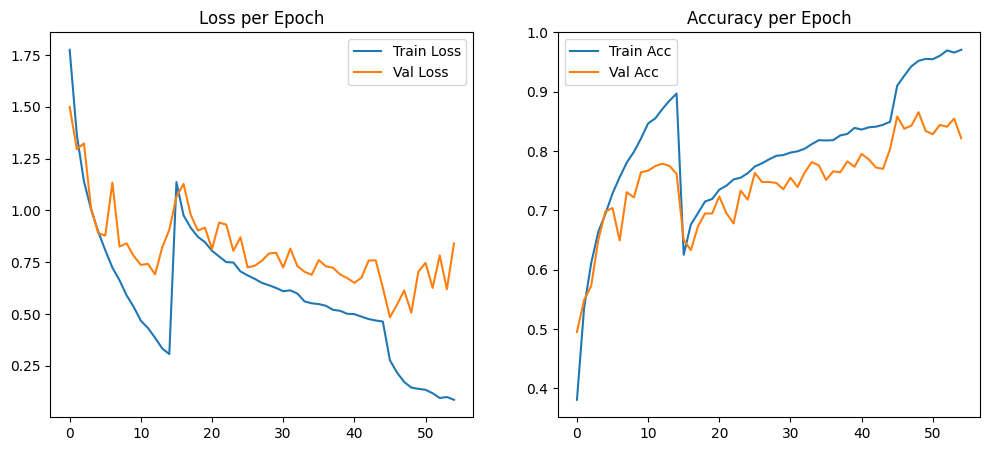

In [33]:
plot_training_history(history)

Test Accuracy: 0.8688
F1 Score (weighted): 0.8682
Classification Report:
              precision    recall  f1-score   support

   butterfly       0.87      0.93      0.90       439
         cat       0.86      0.80      0.83       323
     chicken       0.95      0.89      0.92       597
         cow       0.80      0.75      0.77       386
         dog       0.81      0.91      0.86       941
    elephant       0.80      0.91      0.85       290
       horse       0.87      0.79      0.83       520
       sheep       0.88      0.76      0.81       394
      spider       0.93      0.95      0.94       971
    squirrel       0.89      0.83      0.86       374

    accuracy                           0.87      5235
   macro avg       0.86      0.85      0.86      5235
weighted avg       0.87      0.87      0.87      5235



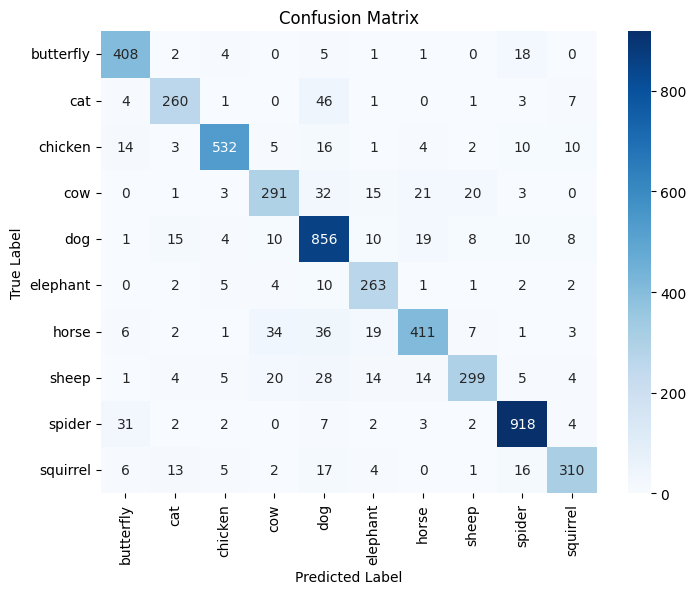

In [20]:
evaluate_model(cnn, test_dl, device)

In [24]:
print("\nStage 4: Light aug again + LR 0.00001")
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.00001)
train_dl_stage4,val_dl_stage4 = update_dataloaders(get_transform("light"), get_transform("light"))
cnn, history4 = train_model(cnn, train_dl_stage4, val_dl_stage4, device, optimizer, epochs=10)


Stage 4: Light aug again + LR 0.00001
Epoch 1/10 | Train Loss: 0.0996 | Train Acc: 0.9667 | Val Loss: 0.4865 | Val Acc: 0.8801
Epoch 2/10 | Train Loss: 0.0843 | Train Acc: 0.9728 | Val Loss: 0.4753 | Val Acc: 0.8782
Epoch 3/10 | Train Loss: 0.0831 | Train Acc: 0.9727 | Val Loss: 0.4731 | Val Acc: 0.8778
Epoch 4/10 | Train Loss: 0.0795 | Train Acc: 0.9744 | Val Loss: 0.4788 | Val Acc: 0.8744
Epoch 5/10 | Train Loss: 0.0734 | Train Acc: 0.9763 | Val Loss: 0.4777 | Val Acc: 0.8767
Epoch 6/10 | Train Loss: 0.0693 | Train Acc: 0.9780 | Val Loss: 0.4643 | Val Acc: 0.8805
Epoch 7/10 | Train Loss: 0.0693 | Train Acc: 0.9779 | Val Loss: 0.4891 | Val Acc: 0.8797
Epoch 8/10 | Train Loss: 0.0721 | Train Acc: 0.9785 | Val Loss: 0.4825 | Val Acc: 0.8793
Epoch 9/10 | Train Loss: 0.0657 | Train Acc: 0.9805 | Val Loss: 0.4857 | Val Acc: 0.8763
Epoch 10/10 | Train Loss: 0.0664 | Train Acc: 0.9801 | Val Loss: 0.4828 | Val Acc: 0.8805


In [45]:
all_history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for hist in [history, history4]:
    for key in all_history:
        all_history[key].extend(hist[key])

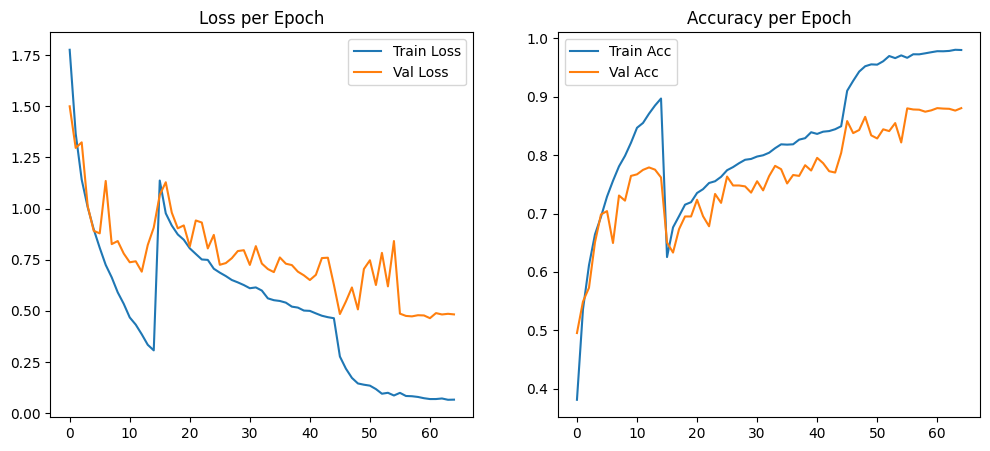

In [46]:
plot_training_history(all_history)

Test Accuracy: 0.8877
F1 Score (weighted): 0.8873
Classification Report:
              precision    recall  f1-score   support

   butterfly       0.92      0.92      0.92       439
         cat       0.88      0.86      0.87       323
     chicken       0.92      0.91      0.92       597
         cow       0.84      0.77      0.80       386
         dog       0.84      0.90      0.87       941
    elephant       0.90      0.89      0.89       290
       horse       0.84      0.86      0.85       520
       sheep       0.88      0.79      0.83       394
      spider       0.94      0.96      0.95       971
    squirrel       0.88      0.87      0.87       374

    accuracy                           0.89      5235
   macro avg       0.89      0.87      0.88      5235
weighted avg       0.89      0.89      0.89      5235



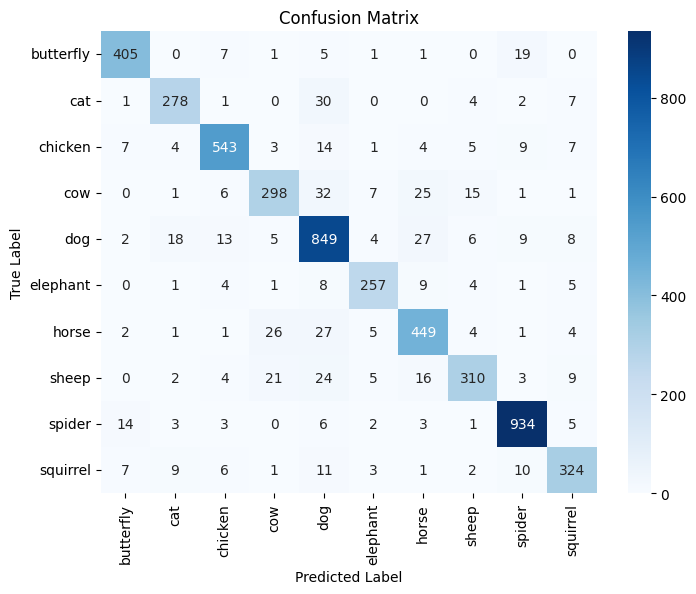

In [37]:
evaluate_model(cnn, test_dl, device)

**Nothing really has improved for stage 5 (results below), so only 4 stages remains.**

In [38]:
print("\nStage 5: Light aug again + LR 0.000001")
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.000001)
train_dl_stage5,val_dl_stage5 = update_dataloaders(get_transform("light"), get_transform("light"))
cnn1, history5 = train_model(cnn, train_dl_stage5, val_dl_stage5, device, optimizer, epochs=5)


Stage 5: Light aug again + LR 0.000001
Epoch 1/5 | Train Loss: 0.0682 | Train Acc: 0.9793 | Val Loss: 0.4897 | Val Acc: 0.8790
Epoch 2/5 | Train Loss: 0.0708 | Train Acc: 0.9772 | Val Loss: 0.4776 | Val Acc: 0.8809
Epoch 3/5 | Train Loss: 0.0700 | Train Acc: 0.9799 | Val Loss: 0.4749 | Val Acc: 0.8778
Epoch 4/5 | Train Loss: 0.0688 | Train Acc: 0.9784 | Val Loss: 0.4701 | Val Acc: 0.8809
Epoch 5/5 | Train Loss: 0.0686 | Train Acc: 0.9780 | Val Loss: 0.4588 | Val Acc: 0.8870


Test Accuracy: 0.8888
F1 Score (weighted): 0.8884
Classification Report:
              precision    recall  f1-score   support

   butterfly       0.91      0.92      0.92       439
         cat       0.89      0.84      0.86       323
     chicken       0.93      0.91      0.92       597
         cow       0.80      0.79      0.79       386
         dog       0.87      0.90      0.88       941
    elephant       0.89      0.90      0.90       290
       horse       0.85      0.86      0.86       520
       sheep       0.86      0.78      0.82       394
      spider       0.94      0.96      0.95       971
    squirrel       0.90      0.87      0.88       374

    accuracy                           0.89      5235
   macro avg       0.88      0.87      0.88      5235
weighted avg       0.89      0.89      0.89      5235



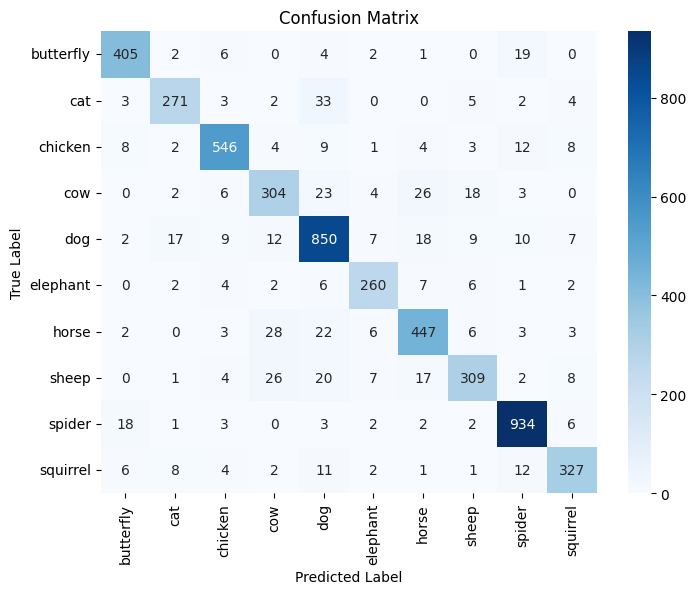

In [40]:
evaluate_model(cnn1, test_dl, device)

In [41]:
def show_misclassified_images(model, dataloader, class_names, device, max_images=10):
    model.eval()
    misclassified_images = []
    misclassified_preds = []
    misclassified_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for img, pred, label in zip(images, preds, labels):
                if pred != label:
                    misclassified_images.append(img.cpu())
                    misclassified_preds.append(pred.cpu())
                    misclassified_labels.append(label.cpu())

                if len(misclassified_images) >= max_images:
                    break
            if len(misclassified_images) >= max_images:
                break

    plt.figure(figsize=(15, 5))
    for i in range(len(misclassified_images)):
        plt.subplot(1, len(misclassified_images), i + 1)
        img = misclassified_images[i].permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())
        plt.imshow(img)
        plt.title(f"True: {class_names[misclassified_labels[i]]}\nPred: {class_names[misclassified_preds[i]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

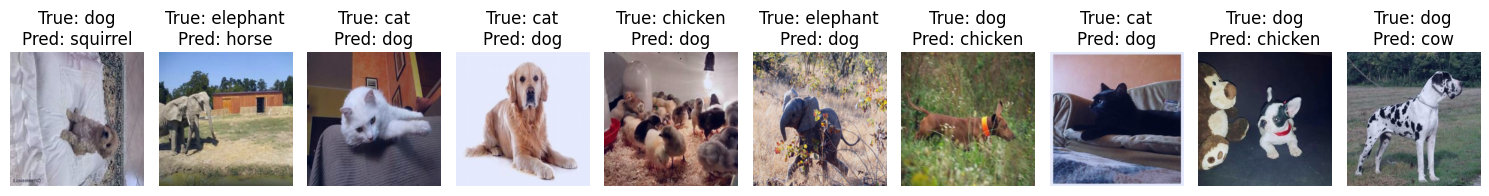

In [42]:
show_misclassified_images(cnn, val_dl_stage4, dataset.classes, device)

**Висновок:**
Порівнюючи з базовою моделлю:

Додано два згорткові шари (conv4, conv5).

Змінено розмірність вхідних даних у fc1 (256×7×7 замість 128×28×28 - через додактові попередні шари).

Збільшено dropout з 0.1 до 0.3.

conv1x1 адаптовано до 256 каналів.


Навчання проводилося так:

15 epochs on lightly augmented data

30 epochs on hardly augmented data

10 epochs on lightly augmented data

Потім були подальші спроби навчання на lightly augmented data, але зі зміною lr:

10 epochs with lr 0.00001

Інші спроби знизити lr не дали набагато кращих результатів, тому на цьому навчання закінчилося.

**Test Accuracy: 0.8877; F1 Score (weighted): 0.8873**


In [43]:
new_path = '/kaggle/working/better-cnn-animal10.pth'
torch.save(cnn.state_dict(), new_path)